<a href="https://colab.research.google.com/github/zakaria409/Audio_DeepFake_Detection/blob/main/development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

tariqblecher_urban_sound_8k_path = kagglehub.dataset_download('tariqblecher/urban-sound-8k')
zakariasameh_fused_data_path = kagglehub.dataset_download('zakariasameh/fused-data')
zakariasameh_asvtest_path = kagglehub.dataset_download('zakariasameh/asvtest')

print('Data source import complete.')


# Ingestion

In [ ]:
import pickle
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import librosa
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers


# Load X
with open('../input/fused-data/Fused Data/X_fused.pkl', 'rb') as f:
    X = pickle.load(f)

# Load y
with open('../input/fused-data/Fused Data/y_fused.pkl', 'rb') as f:
    y = pickle.load(f)

2025-02-25 09:55:51.698106: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-25 09:55:51.698258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-25 09:55:51.873253: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# EDA

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd

# Assuming X has shape (36502, 40, 500), we reshape it to (36502*40, 500)
X_reshaped = X.reshape(-1, 500)  # Shape: (36502*40, 500)

# Apply PCA to reduce 500 -> 1
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_reshaped)  # Shape: (36502*40, 1)

# Compute Information Loss
explained_variance = np.sum(pca.explained_variance_ratio_)
information_loss = 1 - explained_variance

print(f"Explained Variance Retained: {explained_variance:.6f}")
print(f"Information Loss: {information_loss:.6f}")

Explained Variance Retained: 0.535791
Information Loss: 0.464209


In [ ]:
# Apply PCA to reduce 500 -> 50
pca = PCA(n_components=50)
X_pca50 = pca.fit_transform(X_reshaped)  # Shape: (36502*40, 50)

# Reshape back to (36502, 40, 50)
X_reduced50 = X_pca50.reshape(36502, 40, 50)  # Shape: (36502, 40, 50)

# Compute Information Loss
explained_variance = np.sum(pca.explained_variance_ratio_)
information_loss = 1 - explained_variance

print(f"Explained Variance Retained: {explained_variance:.6f}")
print(f"Information Loss: {information_loss:.6f}")

Explained Variance Retained: 0.942804
Information Loss: 0.057196


In [ ]:
X_reduced50?

Type:        ndarray
String form:
[[[ 2.97361695e+03 -1.73475898e+03  8.80872639e+02 ...  1.15865298e+02
           -6.23233390e+01 -2.4267 <...> 799e+01  2.69261099e+00 -2.77897232e+00 ...  1.77887715e+00
           1.07476114e+00  2.70516186e+00]]]
Length:      36502
File:        /opt/conda/lib/python3.10/site-packages/numpy/__init__.py
Docstring:  
ndarray(shape, dtype=float, buffer=None, offset=0,
        strides=None, order=None)

An array object represents a multidimensional, homogeneous array
of fixed-size items.  An associated data-type object describes the
format of each element in the array (its byte-order, how many bytes it
occupies in memory, whether it is an integer, a floating point number,
or something else, etc.)

Arrays should be constructed using `array`, `zeros` or `empty` (refer
to the See Also section below).  The parameters given here refer to
a low-level method (`ndarray(...)`) for instantiating an array.

For more information, refer to the `numpy` module and exa

In [ ]:
# Reshape back to (36502, 40)
X_reduced = X_pca.reshape(36502, 40)

# Convert to DataFrame
df_X = pd.DataFrame(X_reduced)
df_y = pd.DataFrame(y, columns=['target'])

# Concatenate X and y
df = pd.concat([df_X, df_y], axis=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,target
0,2973.616948,155.653352,-43.356267,-63.532521,-101.687445,-95.726501,-91.962059,-89.861271,-88.336877,-90.291571,...,-90.053612,-90.215826,-90.318672,-89.964041,-89.976421,-90.346840,-89.997735,-90.328032,-90.050468,0
1,4570.628931,104.560631,-42.295527,-105.402418,-83.182203,-88.998759,-88.931818,-83.198105,-91.080670,-89.576124,...,-89.322279,-90.291761,-90.759701,-89.434447,-90.109300,-90.344830,-90.071226,-90.347798,-90.189207,0
2,3178.755822,111.204440,-46.998098,-100.057501,-77.101246,-87.118524,-90.394574,-88.922038,-89.111634,-90.711363,...,-90.342942,-90.192985,-90.192767,-90.270229,-90.238107,-90.210117,-90.259726,-90.216867,-90.145101,0
3,3789.625722,147.319347,-15.779415,-66.820880,-110.918314,-98.397921,-90.058611,-88.147160,-88.936060,-90.309266,...,-90.257805,-90.525555,-90.703024,-90.382241,-90.498486,-90.479392,-90.169081,-90.241111,-90.246992,0
4,3929.233606,130.937305,-43.053256,-73.239046,-80.952258,-91.957732,-88.463654,-89.047889,-89.840172,-89.904891,...,-90.284560,-90.354557,-90.481958,-90.414504,-90.134620,-89.968880,-89.968917,-90.114184,-90.044956,0


<Figure size 1500x500 with 0 Axes>

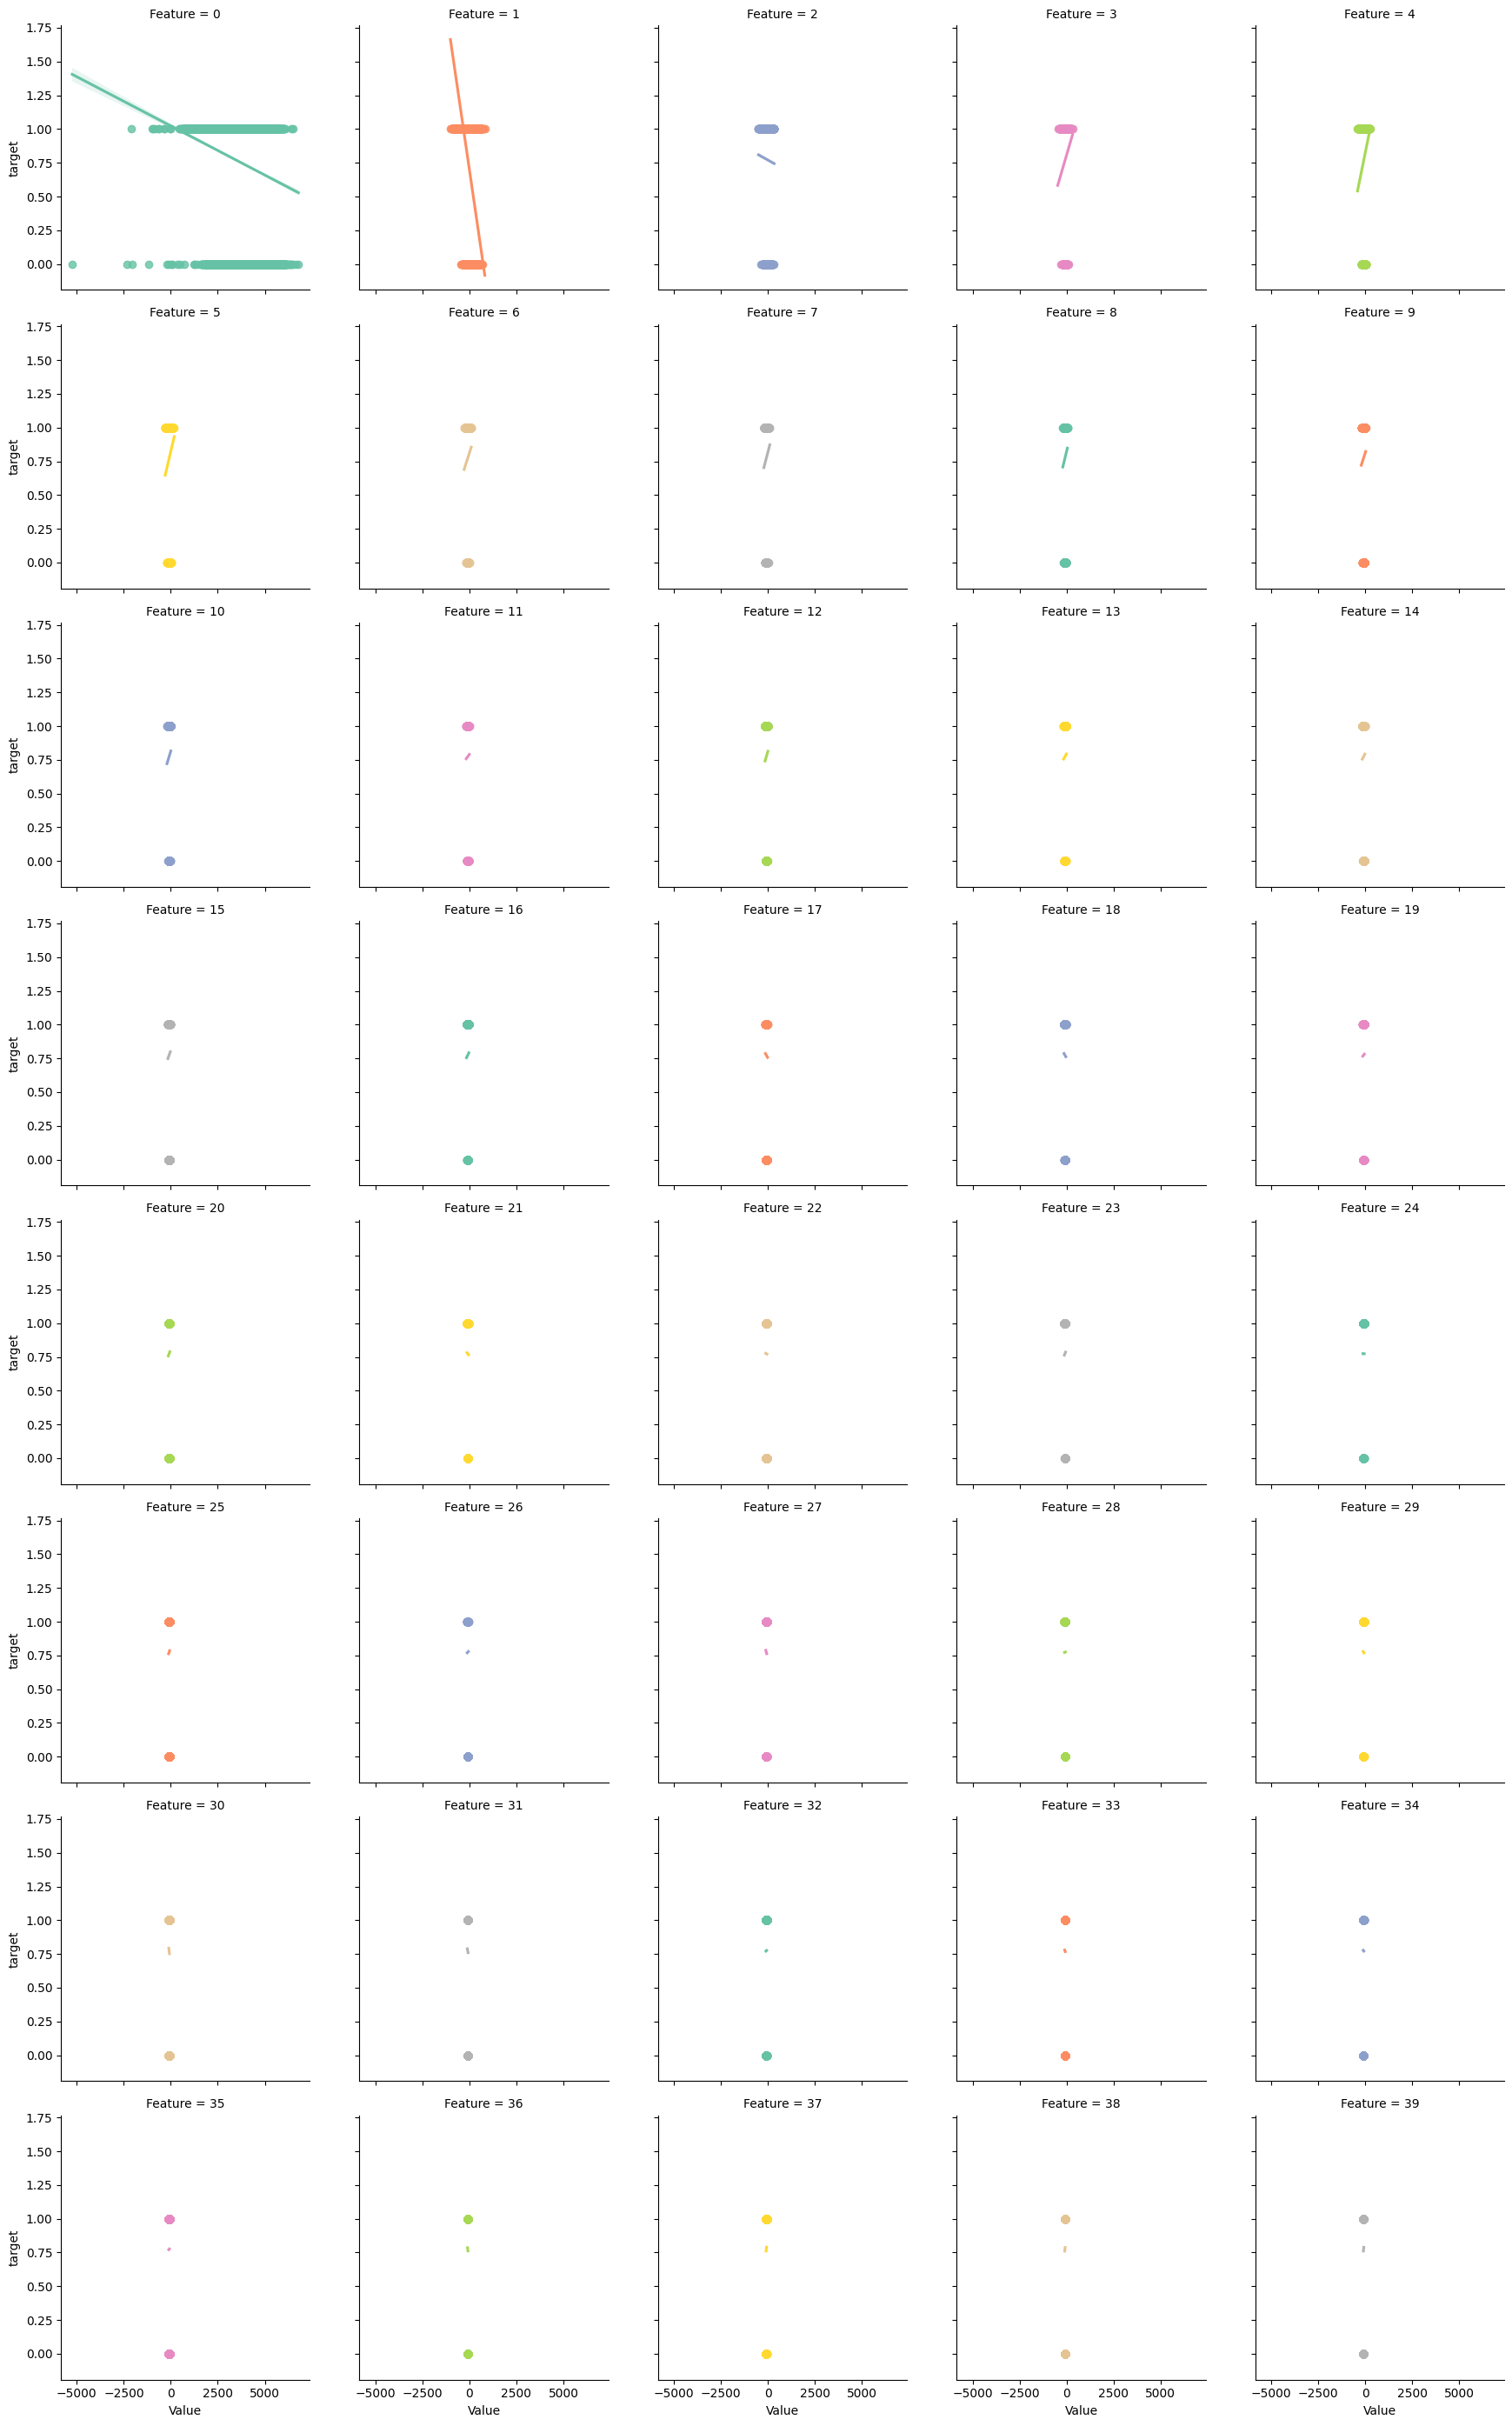

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create DataFrame
df_X = pd.DataFrame(X_reduced)
df_X['target'] = y  # Add target column

# Melt DataFrame to make it long-form for Seaborn
df_melted = df_X.melt(id_vars=['target'], var_name="Feature", value_name="Value")

# Plot
plt.figure(figsize=(15, 5))
ax = sns.lmplot(x="Value", y="target",
                height=3.5,
                col="Feature",  # Create separate plots for each feature
                col_wrap=5,
                hue="Feature",
                palette="Set2",
                data=df_melted)

# Adjust spacing
ax.fig.subplots_adjust(wspace=.2)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

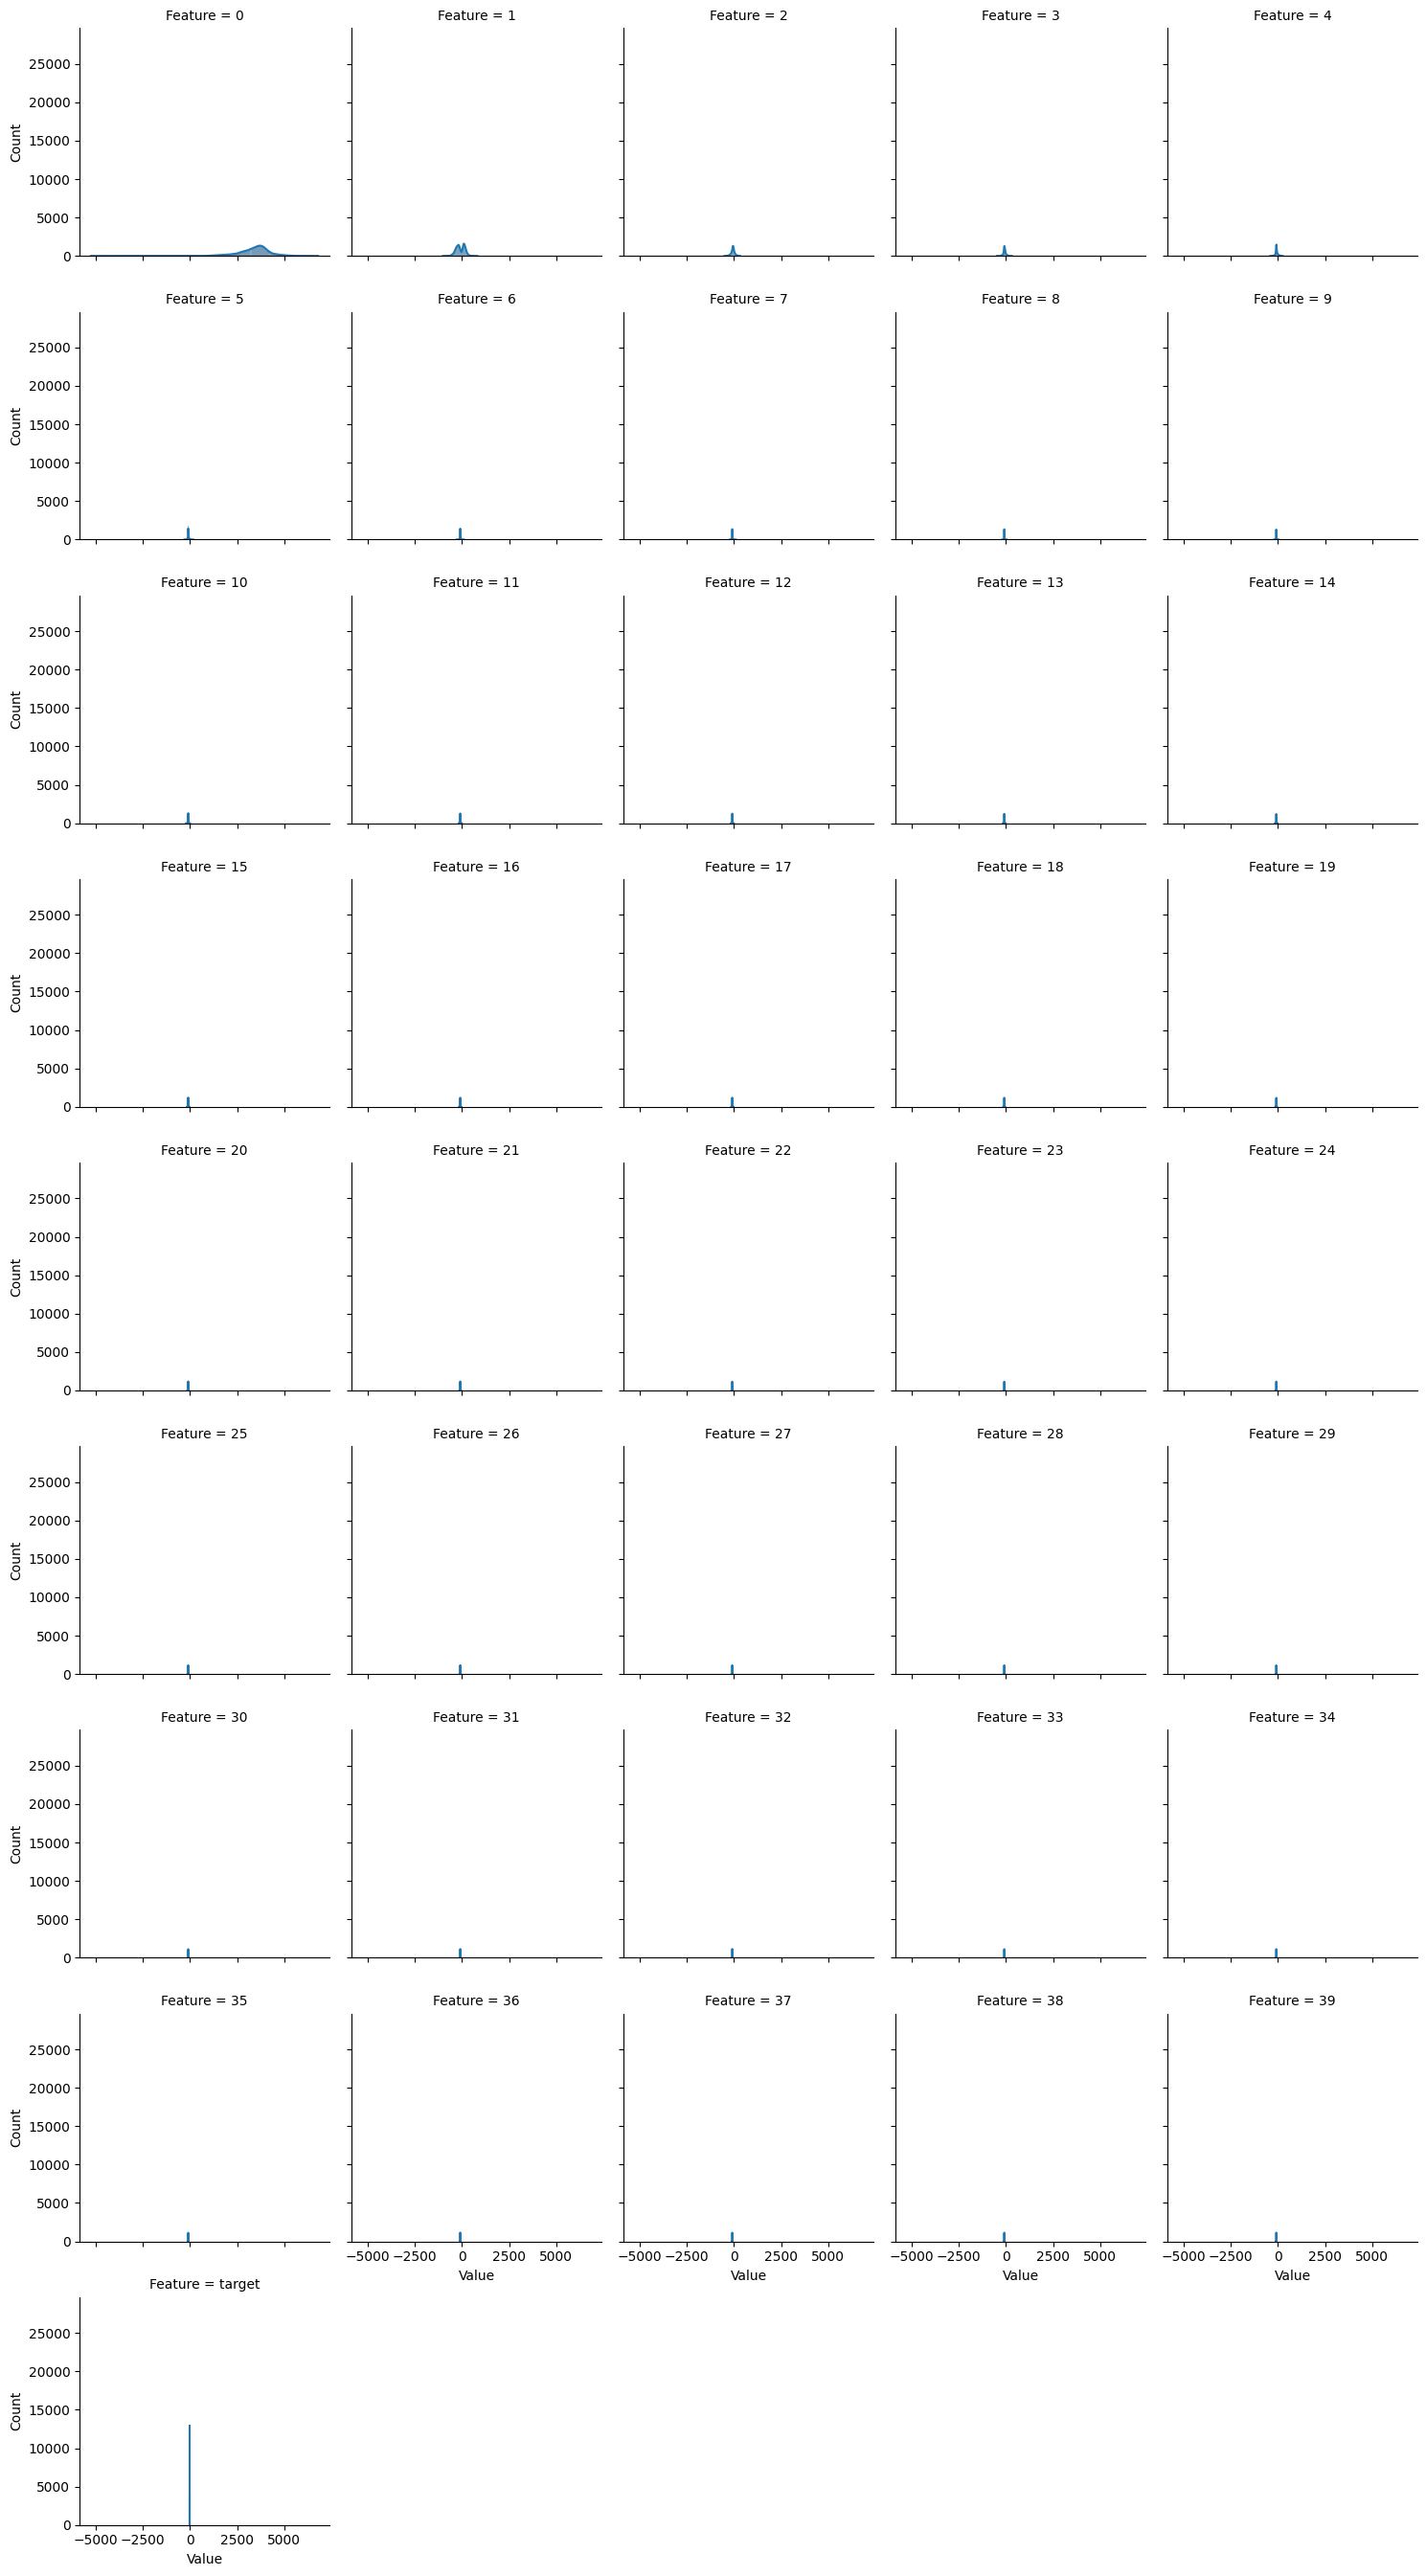

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assume df_X is your (36502 x 40) DataFrame
df_melted = df_X.melt(var_name="Feature", value_name="Value")

g = sns.FacetGrid(df_melted, col="Feature", col_wrap=5, height=3)
g.map(sns.histplot, "Value", kde=True)
plt.show()

<Figure size 1200x500 with 0 Axes>

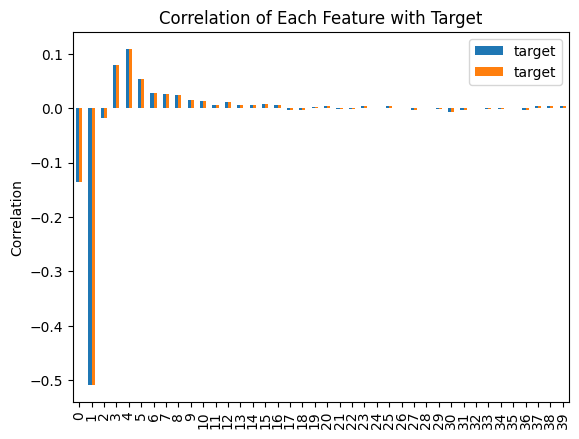

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.concat([df_X, pd.Series(y, name='target')], axis=1)

# Compute correlation of each feature with the target
corr_with_target = df.corr()['target'].drop('target')  # drop target itself

# Plot the correlations
plt.figure(figsize=(12, 5))
corr_with_target.plot(kind='bar')
plt.title("Correlation of Each Feature with Target")
plt.ylabel("Correlation")
plt.show()

In [ ]:
df2 = df.iloc[:,:-30]
df2 = pd.concat([df2, df_y], axis=1)
df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,target
0,2973.616948,155.653352,-43.356267,-63.532521,-101.687445,-95.726501,-91.962059,-89.861271,-88.336877,-90.291571,-87.300493,-90.463963,0
1,4570.628931,104.560631,-42.295527,-105.402418,-83.182203,-88.998759,-88.931818,-83.198105,-91.080670,-89.576124,-83.860477,-89.425167,0
2,3178.755822,111.204440,-46.998098,-100.057501,-77.101246,-87.118524,-90.394574,-88.922038,-89.111634,-90.711363,-90.906039,-90.197258,0
3,3789.625722,147.319347,-15.779415,-66.820880,-110.918314,-98.397921,-90.058611,-88.147160,-88.936060,-90.309266,-87.323065,-93.635523,0
4,3929.233606,130.937305,-43.053256,-73.239046,-80.952258,-91.957732,-88.463654,-89.047889,-89.840172,-89.904891,-91.347867,-91.483959,0


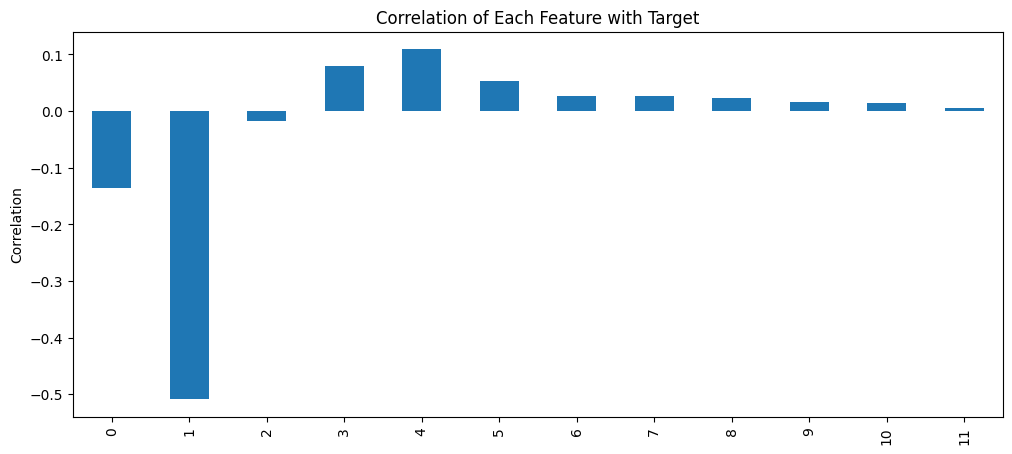

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#df = pd.concat([df_X, pd.Series(y, name='target')], axis=1)

# Compute correlation of each feature with the target
corr_with_target = df2.corr()['target'].drop('target')  # drop target itself

# Plot the correlations
plt.figure(figsize=(12, 5))
corr_with_target.plot(kind='bar')
plt.title("Correlation of Each Feature with Target")
plt.ylabel("Correlation")
plt.show()

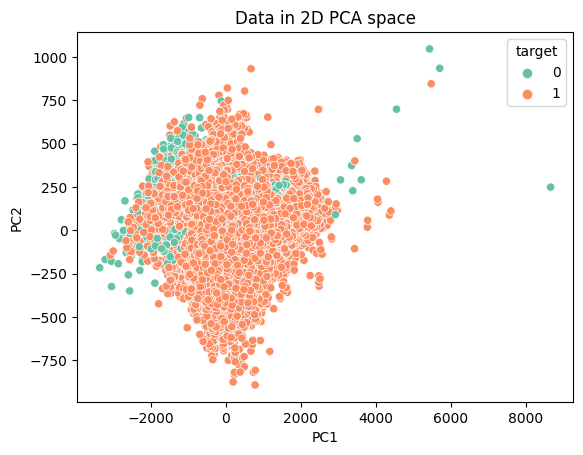

In [ ]:
from sklearn.decomposition import PCA

# Ensure all column names are strings
df_X.columns = df_X.columns.astype(str)

pca_2d = PCA(n_components=2)
X_2D = pca_2d.fit_transform(df_X)  # shape: (36502, 2)

df_2D = pd.DataFrame(X_2D, columns=['PC1', 'PC2'])
df_2D['target'] = y

sns.scatterplot(data=df_2D, x='PC1', y='PC2', hue='target', palette='Set2')
plt.title("Data in 2D PCA space")
plt.show()

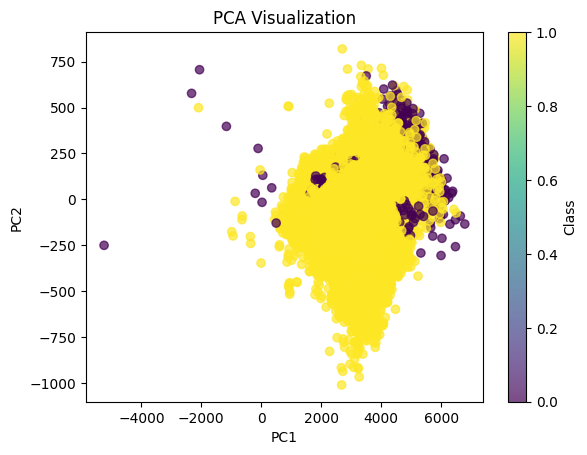

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
#X_reduced = pca.fit_transform(X.reshape(X.shape[0], -1))  # Flatten features
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(label='Class')
plt.title('PCA Visualization')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px

# Suppose df_X is your DataFrame with shape (n_samples, n_features)
# and y is your target array (length n_samples).

# Step 1: Reduce to 3 components
pca_3d = PCA(n_components=3)
X_3D = pca_3d.fit_transform(df_X)  # shape: (n_samples, 3)

# Step 2: Create a DataFrame for Plotly
df_3D = pd.DataFrame(X_3D, columns=['PC1', 'PC2', 'PC3'])
df_3D['target'] = y

# Step 3: Plot with Plotly Express
# If 'target' is categorical, color will be discrete.
# If 'target' is continuous, color will be a gradient.
fig = px.scatter_3d(
    df_3D,
    x='PC1',
    y='PC2',
    z='PC3',
    color='target',  # or color=df_3D['target'].astype(str) if you want discrete
    title='3D PCA Projection'
)

fig.show()

# Modeling

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

def Plot_history(model, X_train, y_train, X_test, y_test, history, class_names):
    # Generate predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Convert y_test to class labels if one-hot encoded
    if y_test.ndim > 1:
        y_test_classes = np.argmax(y_test, axis=1)
    else:
        y_test_classes = y_test

    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


    # Confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.subplot(1, 3, 3)
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()


    # Classification report
    print("Classification Report:")
    print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))


In [ ]:
X = X_reduced50[:, :12, :]
y = y

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# Display the shapes to verify:
print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (32851, 12, 50) (32851,)
Validation set shape: (1825, 12, 50) (1825,)
Test set shape: (1826, 12, 50) (1826,)


In [ ]:
ones = np.sum(y_train)
zeros = len(y_train) - ones
print(f'ones {ones}')
print(f'zeros {zeros}')

ones 25410
zeros 7441


## Transformer

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# Define the Transformer encoder block
def encoder_block(inputs, d_model, num_heads, dropout):
    # Multi-head self-attention
    attn_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=d_model, dropout=dropout
    )(inputs, inputs)
    attn_output = layers.Dropout(dropout)(attn_output)
    attn_output = layers.LayerNormalization(epsilon=1e-6)(attn_output + inputs)

    # Feed Forward Network
    ffn_output = layers.Dense(d_model * 4, activation="relu")(attn_output)
    ffn_output = layers.Dense(d_model)(ffn_output)
    ffn_output = layers.Dropout(dropout)(ffn_output)
    outputs = layers.LayerNormalization(epsilon=1e-6)(attn_output + ffn_output)

    return outputs

# Transformer Model for Numerical Features
def transformer_tabular(input_shape, num_layers, d_model, num_heads, dropout, reg_value=0.01):
    inputs = keras.Input(shape=input_shape, name="inputs")  # Shape: (12,)

    # Feature-wise Normalization
    x = layers.LayerNormalization()(inputs)

    # Project features to d_model dimension
    x = layers.Dense(d_model, activation="relu", name="feature_projection")(x)

    # Expand dimensions to (batch, 12, d_model) to treat as a "sequence" for attention
    x = layers.Reshape((input_shape[0], d_model))(x)

    # Apply multiple Transformer encoder layers
    for _ in range(num_layers):
        x = encoder_block(x, d_model, num_heads, dropout)

    # Global Average Pooling over features
    x = layers.GlobalAveragePooling1D()(x)

    # Dense layers
    x = layers.Dense(d_model, activation="relu", kernel_regularizer=regularizers.l2(reg_value))(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(d_model // 2, activation="relu", kernel_regularizer=regularizers.l2(reg_value))(x)
    x = layers.Dropout(dropout)(x)

    # Output layer (change activation based on task)
    outputs = layers.Dense(2, activation="softmax", name="outputs")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="TabularTransformer")
    return model

# Model Parameters
input_shape = X_train.shape[1:]
num_layers = 4
d_model = 32
num_heads = 4
dropout = 0.25
reg_value = 0.08

# Build model
TTmodel = transformer_tabular(input_shape, num_layers, d_model, num_heads, dropout, reg_value)
TTmodel.summary()

Model: "TabularTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 12, 50)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 50)    │        100 │ inputs[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_projection  │ (None, 12, 32)    │      1,632 │ layer_normalizat… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 12, 32)    │          0 │ feature_projecti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 12, 32)    │     16,800 │ reshape_2[0][0],  │
│ (MultiHeadAttentio… │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_54          │ (None, 12, 32)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_19 (Add)        │ (None, 12, 32)    │          0 │ dropout_54[0][0], │
│                     │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 32)    │         64 │ add_19[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 12, 128)   │      4,224 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 12, 32)    │      4,128 │ dense_45[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_55          │ (None, 12, 32)    │          0 │ dense_46[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 12, 32)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_55[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 32)    │         64 │ add_20[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 12, 32)    │     16,800 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_57          │ (None, 12, 32)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 12, 32)    │          0 │ dropout_57[0][0], │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 32)    │         64 │ add_21[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 12, 128)   │      4,224 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 104,470 (408.09 KB)

 Trainable params: 104,470 (408.09 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    'accuracy',
]

In [ ]:
# Define the optimizer with a very small learning rate
optimiser = keras.optimizers.Adam(learning_rate=0.00003)

# Reduce L2 regularization strength (e.g., 0.001 instead of 0.02)
TTmodel = transformer_tabular(
    input_shape=input_shape,
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dropout=0.3,
    reg_value=0.2
)
early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        verbose=1,
        patience=5,
        mode='min',
        restore_best_weights=True,
        )


# Compile the model
TTmodel.compile(
    optimizer=optimiser,
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Train with callbacks
est_transformer = TTmodel.fit(
    X_train, y_train,
    class_weight=class_weight_dict,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=100,  # Allow more epochs for convergence
    callbacks=[early_stopping]
)

# Evaluate
test_loss, test_acc = TTmodel.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 79s 39ms/step - accuracy: 0.6159 - loss: 10.7740 - val_accuracy: 0.7403 - val_loss: 8.6375
Epoch 2/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7188 - loss: 8.1315 - val_accuracy: 0.8000 - val_loss: 6.4994
Epoch 3/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7773 - loss: 6.0951 - val_accuracy: 0.8466 - val_loss: 4.7951
Epoch 4/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8230 - loss: 4.5036 - val_accuracy: 0.8652 - val_loss: 3.4859
Epoch 5/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8446 - loss: 3.2673 - val_accuracy: 0.8477 - val_loss: 2.5234
Epoch 6/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8520 - loss: 2.3412 - val_accuracy: 0.8526 - val_loss: 1.7878
Epoch 7/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8637 - loss: 1.6564 - val_accuracy: 0.8756 - val_loss: 1.2362
Epoch 8/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8684 - loss

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


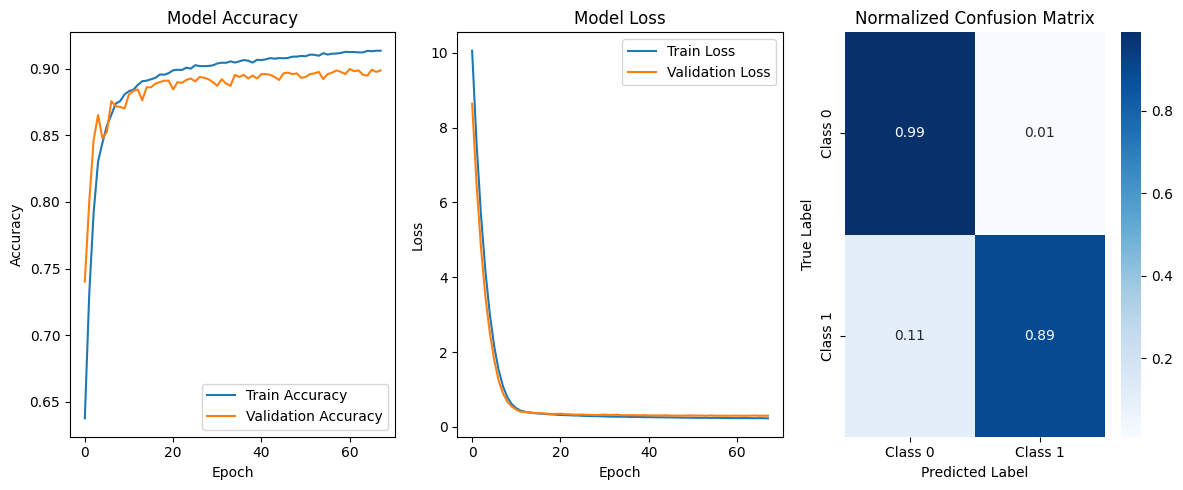

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.73      0.99      0.84       425
     Class 1       1.00      0.89      0.94      1401

    accuracy                           0.91      1826
   macro avg       0.87      0.94      0.89      1826
weighted avg       0.94      0.91      0.92      1826



In [ ]:
class_names = ['Class 0', 'Class 1']
Plot_history(TTmodel, X_train, y_train, X_test, y_test, est_transformer, class_names)

In [ ]:
#class_names = ['Class 0', 'Class 1']
#Plot_history(TTmodel, X_train, y_train, X_test, y_test, est_transformer, class_names)

#Softmax activation from_logits=false

#Classification Report:
#              precision    recall  f1-score   support
#
#     Class 0       0.73      0.99      0.84       425
#     Class 1       1.00      0.89      0.94      1401
#
#    accuracy                           0.91      1826
#   macro avg       0.86      0.94      0.89      1826
#weighted avg       0.93      0.91      0.92      1826

In [ ]:
#model.save("Transformer.h5")

## ResNet

In [ ]:
# Define the ResNet model
def resnet_model(input_shape, num_blocks, filters, kernel_size, dropout,reg_value=0.2, name="resnet"):
    inputs = keras.Input(shape=input_shape, name="inputs")

    # Initial Conv layer
    x = layers.Conv1D(filters=filters, kernel_size=kernel_size, padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # Residual Blocks
    for _ in range(num_blocks):
        x = residual_block(x, filters, kernel_size, dropout)

    # Flatten the output
    x = layers.GlobalAveragePooling1D()(x)

    # Dense layers
    x = layers.Dense(filters * 2, activation="relu", kernel_regularizer=regularizers.l2(reg_value))(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(filters, activation="relu", kernel_regularizer=regularizers.l2(reg_value))(x)
    x = layers.Dropout(dropout)(x)

    # Output layer
    outputs = layers.Dense(2, activation="softmax", name="outputs")(x)

    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    return model

# Define the Residual Block
def residual_block(x, filters, kernel_size, dropout):
    shortcut = x

    # First Conv layer
    x = layers.Conv1D(filters=filters, kernel_size=kernel_size, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)

    # Second Conv layer
    x = layers.Conv1D(filters=filters, kernel_size=kernel_size, padding="same", activation=None)(x)
    x = layers.BatchNormalization()(x)

    # Adding the shortcut to the main path
    x = layers.add([x, shortcut])
    x = layers.Activation("relu")(x)
    return x


# Define parameters
input_shape = X_train.shape[1:]  # Adjust the input shape as per your data
num_blocks = 3
filters = 64
kernel_size = 3
dropout = 0.54
reg_value = 0.3
# Build the model
resnet_model = resnet_model(
    input_shape=input_shape,
    num_blocks=num_blocks,
    filters=filters,
    kernel_size=kernel_size,
    dropout=dropout,
    reg_value=reg_value
)


# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.00001)
early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        verbose=1,
        patience=5,
        mode='min',
        restore_best_weights=True,
    )
resnet_model.compile(optimizer=optimiser,
                     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=['accuracy'])

resnet_model.summary()
# train model
est_resnet = resnet_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    class_weight=class_weight_dict,batch_size=32,
                    epochs=80,callbacks=[early_stopping],)

Model: "resnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 12, 50)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 12, 64)    │      9,664 │ inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 12, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 6, 64)     │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 6, 64)     │     12,352 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 64)     │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 6, 64)     │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 6, 64)     │     12,352 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 64)     │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 6, 64)     │          0 │ batch_normalizat… │
│                     │                   │            │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 6, 64)     │          0 │ add_16[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 6, 64)     │     12,352 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 64)     │        256 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 6, 64)     │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 6, 64)     │     12,352 │ dropout_29[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 64)     │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 6, 64)     │          0 │ batch_normalizat… │
│                     │                   │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 6, 64)     │          0 │ add_17[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 6, 64)     │     12,352 │ activation_1[0][

 Total params: 102,274 (399.51 KB)

 Trainable params: 101,378 (396.01 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/80


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:602: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



1027/1027 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - accuracy: 0.4176 - loss: 50.0225 - val_accuracy: 0.5660 - val_loss: 43.9547
Epoch 2/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5025 - loss: 42.4030 - val_accuracy: 0.6964 - val_loss: 37.1811
Epoch 3/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5446 - loss: 35.7760 - val_accuracy: 0.6992 - val_loss: 31.2256
Epoch 4/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5917 - loss: 29.9415 - val_accuracy: 0.7090 - val_loss: 25.9658
Epoch 5/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6284 - loss: 24.8303 - val_accuracy: 0.7184 - val_loss: 21.3428
Epoch 6/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6732 - loss: 20.3302 - val_accuracy: 0.7326 - val_loss: 17.3132
Epoch 7/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7222 - loss: 16.4235 - val_accuracy: 0.7682 - val_loss: 13.8334
Epoch 8/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7608 - loss: 13.0

In [ ]:
# evaluate model on test set
ev = resnet_model.evaluate(X_test, y_test, verbose=2)
ev

58/58 - 1s - 12ms/step - accuracy: 0.9069 - loss: 0.2812


[0.2812096178531647, 0.9069003462791443]

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


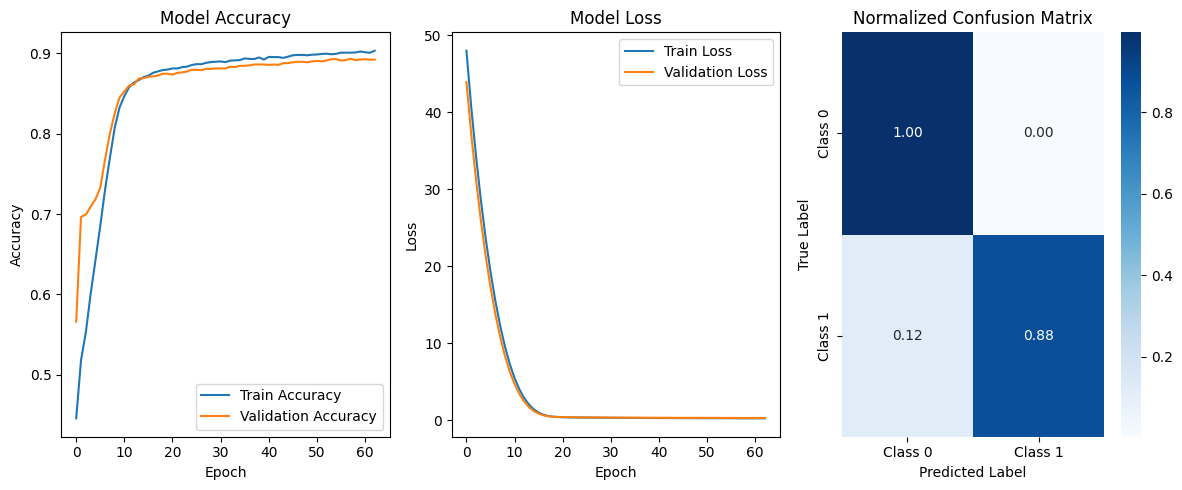

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.72      1.00      0.83       425
     Class 1       1.00      0.88      0.94      1401

    accuracy                           0.91      1826
   macro avg       0.86      0.94      0.88      1826
weighted avg       0.93      0.91      0.91      1826



In [ ]:
class_names = ['Class 0', 'Class 1']  # Replace with your actual class names
Plot_history(resnet_model, X_train, y_train, X_test, y_test, est_resnet, class_names)

In [ ]:
#model.save("/kaggle/working/resnet-fused.h5")

In [ ]:
#del model

## Wave-U-Net

In [ ]:
def wave_unet_model(input_shape, num_layers, filters, kernel_size, dropout, name="wave_unet"):
    inputs = keras.Input(shape=input_shape, name="inputs")


    # Encoder (Downsampling path)
    skips = []
    for _ in range(num_layers):
        x = layers.Conv1D(filters, kernel_size, padding="same", activation="relu")(inputs)
        x = layers.BatchNormalization()(x)
        skips.append(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        filters *= 2  # Double filters after pooling

    # Bottleneck
    x = layers.Conv1D(filters, kernel_size, padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.1))(x)
    x = layers.BatchNormalization()(x)

    # Decoder (Upsampling path)
    for skip in reversed(skips):
        filters //= 2  # Halve filters before upsampling
        x = layers.Conv1DTranspose(filters, kernel_size, strides=2, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)

        # Align dimensions of skip connection and x
        if skip.shape[1] > x.shape[1]:
            # Pad x to match skip's length
            padding = skip.shape[1] - x.shape[1]
            x = layers.ZeroPadding1D(padding=(0, padding))(x)
        elif skip.shape[1] < x.shape[1]:
            # Crop x to match skip's length
            x = layers.Cropping1D((0, x.shape[1] - skip.shape[1]))(x)

        x = layers.Concatenate()([x, skip])
        x = layers.Conv1D(filters, kernel_size, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)

    # Output layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(filters, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(2, activation="softmax", name="outputs")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    return model

# Define parameters
input_shape = X_train.shape[1:]
num_layers = 4
filters = 16
kernel_size = 2
dropout = 0.6

# Build the model
wave_unet_model = wave_unet_model(
    input_shape=input_shape,
    num_layers=num_layers,
    filters=filters,
    kernel_size=kernel_size,
    dropout=dropout,
)

# Compile and train as before
wave_unet_model.compile(optimizer=keras.optimizers.Adam(0.000006), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
wave_unet_model.summary()

Model: "wave_unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 12, 50)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_79 (Conv1D)  │ (None, 12, 128)   │     12,928 │ inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 128)   │        512 │ conv1d_79[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_29    │ (None, 6, 128)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_80 (Conv1D)  │ (None, 6, 256)    │     65,792 │ max_pooling1d_29… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 256)    │      1,024 │ conv1d_80[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_transpose_25 │ (None, 12, 128)   │     65,664 │ batch_normalizat… │
│ (Conv1DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 128)   │        512 │ conv1d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_25      │ (None, 12, 256)   │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_81 (Conv1D)  │ (None, 12, 128)   │     65,664 │ concatenate_25[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 128)   │        512 │ conv1d_81[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_transpose_26 │ (None, 24, 64)    │     16,448 │ batch_normalizat… │
│ (Conv1DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 64)    │        256 │ conv1d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_78 (Conv1D)  │ (None, 12, 64)    │      6,464 │ inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping1d_16       │ (None, 12, 64)    │          0 │ batch_normalizat… │
│ (Cropping1D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 64)    │        256 │ conv1d_78[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_26      │ (None, 12, 128)   │          0 │ cropping1d_16[0]… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_82 (Conv1D)  │ (None, 12, 64)    │     16,448 │ concatenate_26[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 64)    │        256 │ conv1d_82[0][0] 

 Total params: 268,802 (1.03 MB)

 Trainable params: 266,850 (1.02 MB)

 Non-trainable params: 1,952 (7.62 KB)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        verbose=1,
        patience=5,
        mode='min',
        restore_best_weights=True,
    )
# train model
est_wave_unet = wave_unet_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    class_weight=class_weight_dict,
                    batch_size=32, epochs=100,callbacks=[early_stopping])
# evaluate model on test set
test_loss, test_acc = wave_unet_model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5858 - loss: 14.6654 - val_accuracy: 0.6323 - val_loss: 12.9097
Epoch 2/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6099 - loss: 12.4568 - val_accuracy: 0.6614 - val_loss: 11.0282
Epoch 3/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6296 - loss: 10.6470 - val_accuracy: 0.6866 - val_loss: 9.4218
Epoch 4/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6469 - loss: 9.0951 - val_accuracy: 0.7118 - val_loss: 8.0375
Epoch 5/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6678 - loss: 7.7591 - val_accuracy: 0.7425 - val_loss: 6.8457
Epoch 6/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6842 - loss: 6.6050 - val_accuracy: 0.7742 - val_loss: 5.8179
Epoch 7/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6916 - loss: 5.6222 - val_accuracy: 0.7896 - val_loss: 4.9519
Epoch 8/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7173 - lo

58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


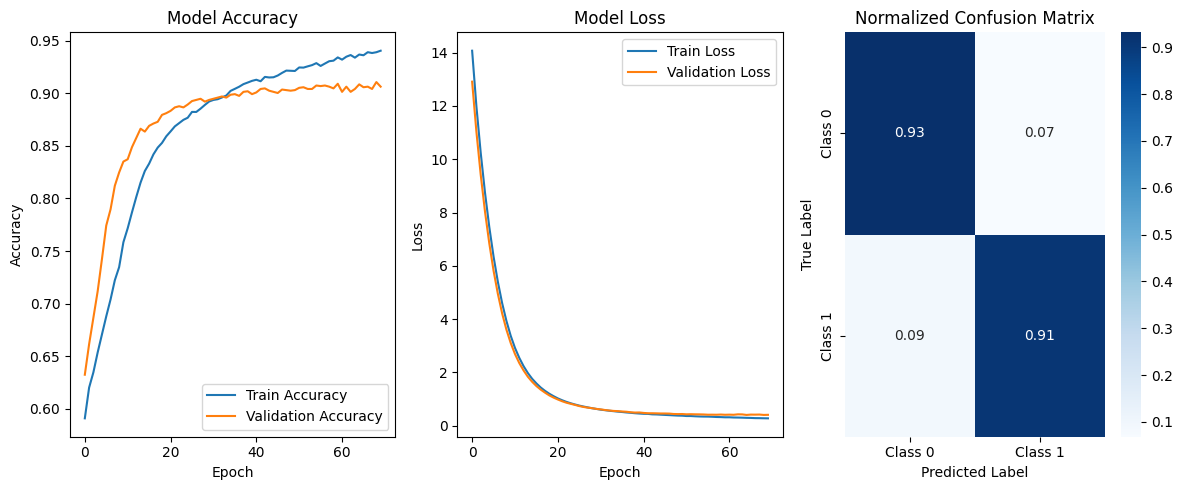

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.76      0.93      0.84       425
     Class 1       0.98      0.91      0.94      1401

    accuracy                           0.92      1826
   macro avg       0.87      0.92      0.89      1826
weighted avg       0.93      0.92      0.92      1826



In [ ]:
class_names = ['Class 0', 'Class 1']  # Replace with your actual class names
Plot_history(wave_unet_model, X_train, y_train, X_test, y_test, est_wave_unet, class_names)

In [ ]:
#model.save("/kaggle/working/Wave-U-Net.h5")

In [ ]:
#from tensorflow.keras.models import load_model
#model = load_model('/kaggle/working/MHT-fused.h5')

## Wave2Vec

In [ ]:
# Define the Wave2Vec model
def wave2vec_model(input_shape, num_layers, units, dropout, reg_type="l2", reg_value=0.01, name="wave2vec"):
    inputs = keras.Input(shape=input_shape, name="inputs")

    # Define regularization based on the provided type
    kernel_regularizer = None
    if reg_type == "l1":
        kernel_regularizer = regularizers.l1(reg_value)
    elif reg_type == "l2":
        kernel_regularizer = regularizers.l2(reg_value)
    elif reg_type == "l1_l2":
        kernel_regularizer = regularizers.l1_l2(l1=reg_value, l2=reg_value)

    # Convolutional feature extractor (similar to Wave2Vec)
    x = layers.Conv1D(128, 10, strides=5, padding='same', activation='relu',
                      kernel_regularizer=kernel_regularizer, name='conv1')(inputs)
    x = layers.Conv1D(128, 8, strides=4, padding='same', activation='relu',
                      kernel_regularizer=kernel_regularizer, name='conv2')(x)
    x = layers.Conv1D(128, 4, strides=2, padding='same', activation='relu',
                      kernel_regularizer=kernel_regularizer, name='conv3')(x)
    x = layers.Conv1D(128, 4, strides=2, padding='same', activation='relu',
                      kernel_regularizer=kernel_regularizer, name='conv4')(x)
    x = layers.Conv1D(128, 4, strides=2, padding='same', activation='relu',
                      kernel_regularizer=kernel_regularizer, name='conv5')(x)
    x = layers.Conv1D(128, 4, strides=2, padding='same', activation='relu',
                      kernel_regularizer=kernel_regularizer, name='conv6')(x)

    # Flatten the output from convolutional layers
    x = layers.GlobalAveragePooling1D()(x)

    # Dense layers with regularization
    x = layers.Dense(units, activation='relu', kernel_regularizer=kernel_regularizer)(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(units // 2, activation='relu', kernel_regularizer=kernel_regularizer)(x)
    x = layers.Dropout(dropout)(x)

    # Output layer
    outputs = layers.Dense(2, activation='softmax', name='outputs')(x)

    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    return model

# Define parameters
input_shape = X_train.shape[1:]
num_layers = 4
units = 64
dropout = 0.6
reg_type="l2"

# Build the model
wave2vec_model = wave2vec_model(
    input_shape=input_shape,
    num_layers=num_layers,
    units=units,
    dropout=dropout,
    reg_type=reg_type,
    reg_value=0.4
)



# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.000006)
early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        verbose=1,
        patience=5,
        mode='min',
        restore_best_weights=True,
    )
wave2vec_model.compile(optimizer=optimiser,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

wave2vec_model.summary()
# train model
est_wave2vec = wave2vec_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        class_weight=class_weight_dict,
                        batch_size=32, epochs=100,callbacks=[early_stopping])
    # evaluate model on test set
test_loss, test_acc = wave2vec_model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

Model: "wave2vec"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv1D)                  │ (None, 3, 128)         │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv1D)                  │ (None, 1, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv1D)                  │ (None, 1, 128)         │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv1D)                  │ (None, 1, 128)         │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv1D)                  │ (None, 1, 128)         │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv1D)                  │ (None, 1, 128)         │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_14     │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 468,386 (1.79 MB)

 Trainable params: 468,386 (1.79 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.5575 - loss: 318.8686 - val_accuracy: 0.7189 - val_loss: 267.3079
Epoch 2/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6174 - loss: 252.3683 - val_accuracy: 0.6975 - val_loss: 210.6138
Epoch 3/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6672 - loss: 198.4579 - val_accuracy: 0.7096 - val_loss: 164.4981
Epoch 4/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6882 - loss: 154.6338 - val_accuracy: 0.7233 - val_loss: 127.1356
Epoch 5/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6964 - loss: 119.2082 - val_accuracy: 0.7408 - val_loss: 97.2004
Epoch 6/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7017 - loss: 90.9201 - val_accuracy: 0.7414 - val_loss: 73.6255
Epoch 7/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7030 - loss: 68.7426 - val_accuracy: 0.7173 - val_loss: 55.4377
Epoch 8/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - ac

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


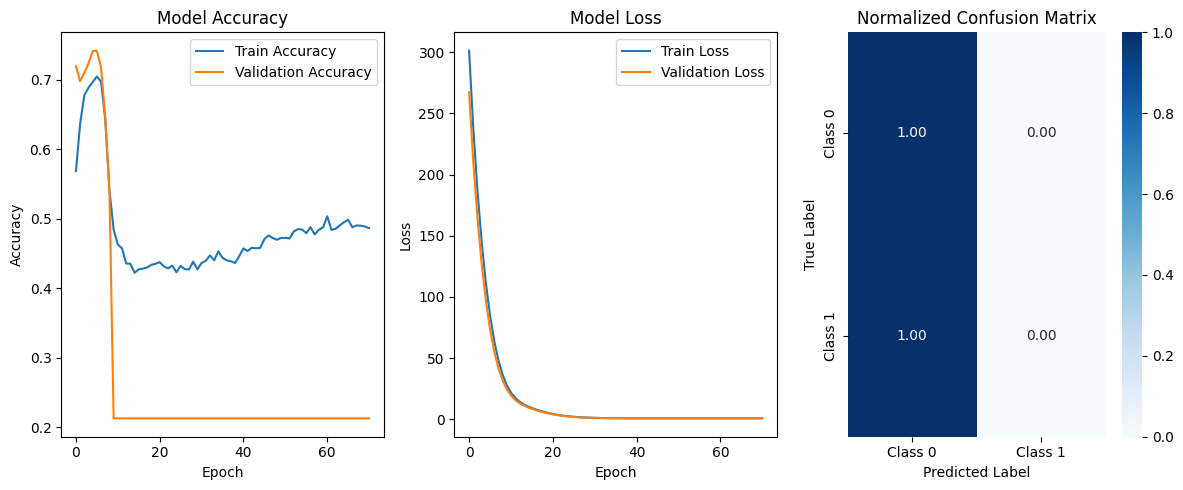

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.23      1.00      0.38       425
     Class 1       0.00      0.00      0.00      1401

    accuracy                           0.23      1826
   macro avg       0.12      0.50      0.19      1826
weighted avg       0.05      0.23      0.09      1826



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
class_names = ['Class 0', 'Class 1']
Plot_history(wave2vec_model, X_train, y_train, X_test, y_test, est_wave2vec, class_names)

## Unet

In [ ]:
def conv_block(inputs, num_filters, l2_reg=0.001, dropout_rate=0.2):
    # First convolutional layer with regularization
    x = layers.Conv1D(num_filters, 3, padding="same",
                     kernel_regularizer=regularizers.l2(l2_reg),
                     activity_regularizer=regularizers.l1(0.001))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.SpatialDropout1D(dropout_rate)(x)  # Better than regular Dropout for conv layers

    # Second convolutional layer with regularization
    x = layers.Conv1D(num_filters, 3, padding="same",
                     kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = layers.MaxPooling1D(2)(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = layers.Conv1DTranspose(num_filters, 3, strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_classes, BN_reg=0.1, l2_reg=0.07, dropout_rate=0.25):
    inputs = keras.Input(shape=input_shape)

    # Encoder with increased dropout
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)

    # Bottleneck with stronger regularization
    b1 = conv_block(p2, 256, l2_reg=BN_reg, dropout_rate=dropout_rate)

    # Decoder
    d1 = decoder_block(b1, s2, 128)
    d2 = decoder_block(d1, s1, 64)

    # Enhanced classifier with regularization
    x = layers.Conv1D(64, 3, padding="same", activation="relu",
                     kernel_regularizer=regularizers.l2(l2_reg))(d2)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation="relu",
                    kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(0.4)(x)  # Increased dropout
    x = layers.Dense(64, activation="relu",
                    kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(0.4)(x)  # Increased dropout
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="Regularized_U-Net")
    return model

# Define parameters
input_shape = X_train.shape[1:]
num_classes = 2

# Build the model
Unet_model = build_unet(
    input_shape=input_shape,
    num_classes=num_classes,
    BN_reg=0.12,
    l2_reg=0.1,
    dropout_rate=0.3
)



# compile model
optimiser = keras.optimizers.Adam(
    learning_rate=0.00001,
)

early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        verbose=1,
        patience=5,
        mode='min',
        restore_best_weights=True,
    )
Unet_model.compile(optimizer=optimiser,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

Unet_model.summary()
# train model
est_unet = Unet_model.fit(X_train, y_train,
                    class_weight=class_weight_dict, validation_data=(X_val, y_val),
                    batch_size=32, epochs=100,callbacks=[early_stopping])
# evaluate model on test set
test_loss, test_acc = Unet_model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

Model: "Regularized_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 12, 50)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_85 (Conv1D)  │ (None, 12, 64)    │      9,664 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 64)    │        256 │ conv1d_85[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 12, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, 12, 64)    │          0 │ re_lu_20[0][0]    │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_86 (Conv1D)  │ (None, 12, 64)    │     12,352 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 64)    │        256 │ conv1d_86[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_21 (ReLU)     │ (None, 12, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_30    │ (None, 6, 64)     │          0 │ re_lu_21[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_87 (Conv1D)  │ (None, 6, 128)    │     24,704 │ max_pooling1d_30… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 128)    │        512 │ conv1d_87[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_22 (ReLU)     │ (None, 6, 128)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, 6, 128)    │          0 │ re_lu_22[0][0]    │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_88 (Conv1D)  │ (None, 6, 128)    │     49,280 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 128)    │        512 │ conv1d_88[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_23 (ReLU)     │ (None, 6, 128)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_31    │ (None, 3, 128)    │          0 │ re_lu_23[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_89 (Conv1D)  │ (None, 3, 256)    │     98,560 │ max_pooling1d_31… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 256)    │      1,024 │ conv1d_89[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_24 (ReLU)     │ (None, 3, 256)    │          0 │ batch_normalizat

 Total params: 733,378 (2.80 MB)

 Trainable params: 730,818 (2.79 MB)

 Non-trainable params: 2,560 (10.00 KB)

Epoch 1/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 44s 23ms/step - accuracy: 0.5214 - loss: 1872.9417 - val_accuracy: 0.6942 - val_loss: 1705.7283
Epoch 2/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5573 - loss: 1664.1466 - val_accuracy: 0.6493 - val_loss: 1512.1494
Epoch 3/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6100 - loss: 1472.5995 - val_accuracy: 0.6362 - val_loss: 1330.4159
Epoch 4/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6724 - loss: 1292.7148 - val_accuracy: 0.5896 - val_loss: 1160.1052
Epoch 5/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6899 - loss: 1122.5918 - val_accuracy: 0.5770 - val_loss: 1000.5508
Epoch 6/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7002 - loss: 964.4200 - val_accuracy: 0.5408 - val_loss: 851.4483
Epoch 7/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6928 - loss: 815.7908 - val_accuracy: 0.5605 - val_loss: 712.5837
Epoch 8/100
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 

58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


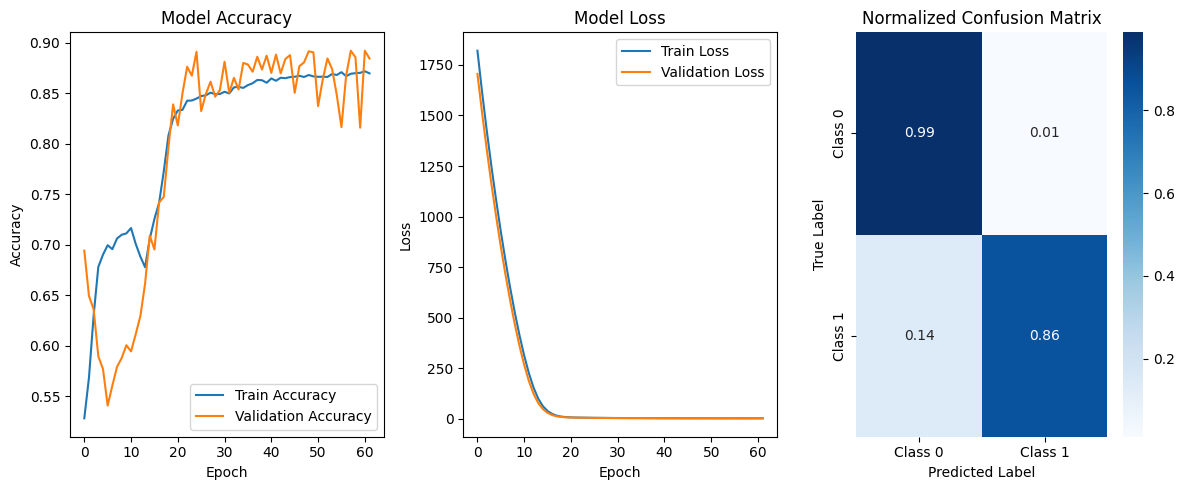

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.69      0.99      0.81       425
     Class 1       1.00      0.86      0.92      1401

    accuracy                           0.89      1826
   macro avg       0.84      0.93      0.87      1826
weighted avg       0.92      0.89      0.90      1826



In [ ]:
class_names = ['Class 0', 'Class 1']  # Replace with your actual class names
Plot_history(Unet_model, X_train, y_train, X_test, y_test, est_unet, class_names)

In [ ]:
#model.save("/kaggle/working/U-Net.h5")

# Conclusion

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import precision_recall_curve

#model.compile(optimizer=optimiser, loss='binary_crossentropy')

train_predictions = []
test_predictions = []

train_predictions.append(TTmodel.predict(X_train, batch_size = 32))
test_predictions.append(TTmodel.predict(X_test, batch_size = 32))

train_predictions.append(resnet_model.predict(X_train, batch_size = 32))
test_predictions.append(resnet_model.predict(X_test, batch_size = 32))

train_predictions.append(wave_unet_model.predict(X_train, batch_size = 32))
test_predictions.append(wave_unet_model.predict(X_test, batch_size = 32))

train_predictions.append(wave2vec_model.predict(X_train, batch_size = 32))
test_predictions.append(wave2vec_model.predict(X_test, batch_size = 32))

train_predictions.append(Unet_model.predict(X_train, batch_size = 32))
test_predictions.append(Unet_model.predict(X_test, batch_size = 32))

1027/1027 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
def plot_roc(ax, name, labels, predictions, **kwargs):
    # If labels are one-hot encoded, convert them to a 1D array
    if labels.ndim > 1 and labels.shape[1] > 1:
        labels = np.argmax(labels, axis=1)

    # If predictions are 2D, use the score for the positive class
    if predictions.ndim > 1 and predictions.shape[1] > 1:
        predictions = predictions[:, 1]

    # Compute ROC curve and AUC
    fp, tp, _ = roc_curve(labels, predictions)
    roc_auc = auc(fp, tp)
    label_with_auc = f"{name} {roc_auc:.3f}"

    # Plot ROC curve on the given axis
    ax.plot(100 * fp, 100 * tp, label=label_with_auc, linewidth=2, **kwargs)
    ax.set_xlabel('False positives [%]')
    ax.set_ylabel('True positives [%]')
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 100])
    ax.grid(True)
    # Optionally remove or adjust this if the aspect ratio is causing issues:
    ax.set_aspect('equal')
    ax.legend()

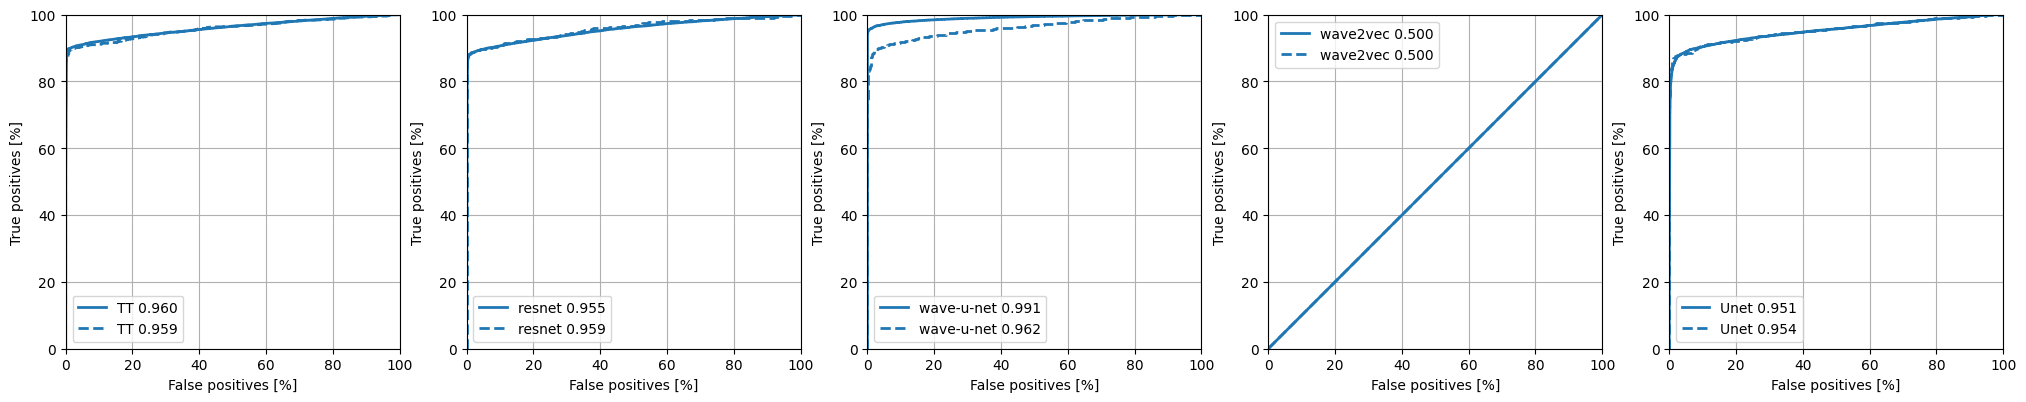

In [ ]:
import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

model_name = ["TT","resnet", "wave-u-net", "wave2vec", "Unet"]


for i in range (5):
    plot_roc(axes[i], model_name[i], y_train, train_predictions[i], color=colors[0])
    plot_roc(axes[i], model_name[i], y_test, test_predictions[i], color=colors[0],linestyle='--')

plt.show()

In [ ]:
# PRC curve
def plot_prc(ax, name, labels, predictions, **kwargs):
    """
    Plots a Precision-Recall Curve on the given axis.

    Parameters:
        ax: Matplotlib Axes on which to plot.
        name: Name of the model (displayed in the legend with its AUC).
        labels: True labels (can be one-hot encoded; they will be converted to 1D if necessary).
        predictions: Predicted probabilities or scores (if 2D, the positive class scores are used).
        **kwargs: Additional keyword arguments passed to the plot() function.
    """
    # Convert one-hot labels to 1D if necessary
    if labels.ndim > 1 and labels.shape[1] > 1:
        labels = np.argmax(labels, axis=1)

    # If predictions are 2D (e.g., softmax outputs), use the positive class probabilities
    if predictions.ndim > 1 and predictions.shape[1] > 1:
        predictions = predictions[:, 1]

    # Compute precision, recall, and thresholds.
    precision, recall, thresholds = precision_recall_curve(labels, predictions)

    # Compute the AUC for the PR curve (using recall as the x-axis)
    pr_auc = auc(recall, precision)
    label_with_auc = f"{name} {pr_auc:.3f}"

    # Plot the PR curve on the provided axis
    ax.plot(recall, precision, label=label_with_auc, linewidth=2, **kwargs)

    # Optionally, you can plot the thresholds as points.
    # Note: thresholds is one element shorter than recall and precision.
    # If desired, you can scatter the thresholds using recall[:-1] or adjust as needed.
    # ax.scatter(recall[:-1], thresholds, label='Thresholds', color='gray', alpha=0.5)

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.grid(True)
    ax.legend(loc='lower right')


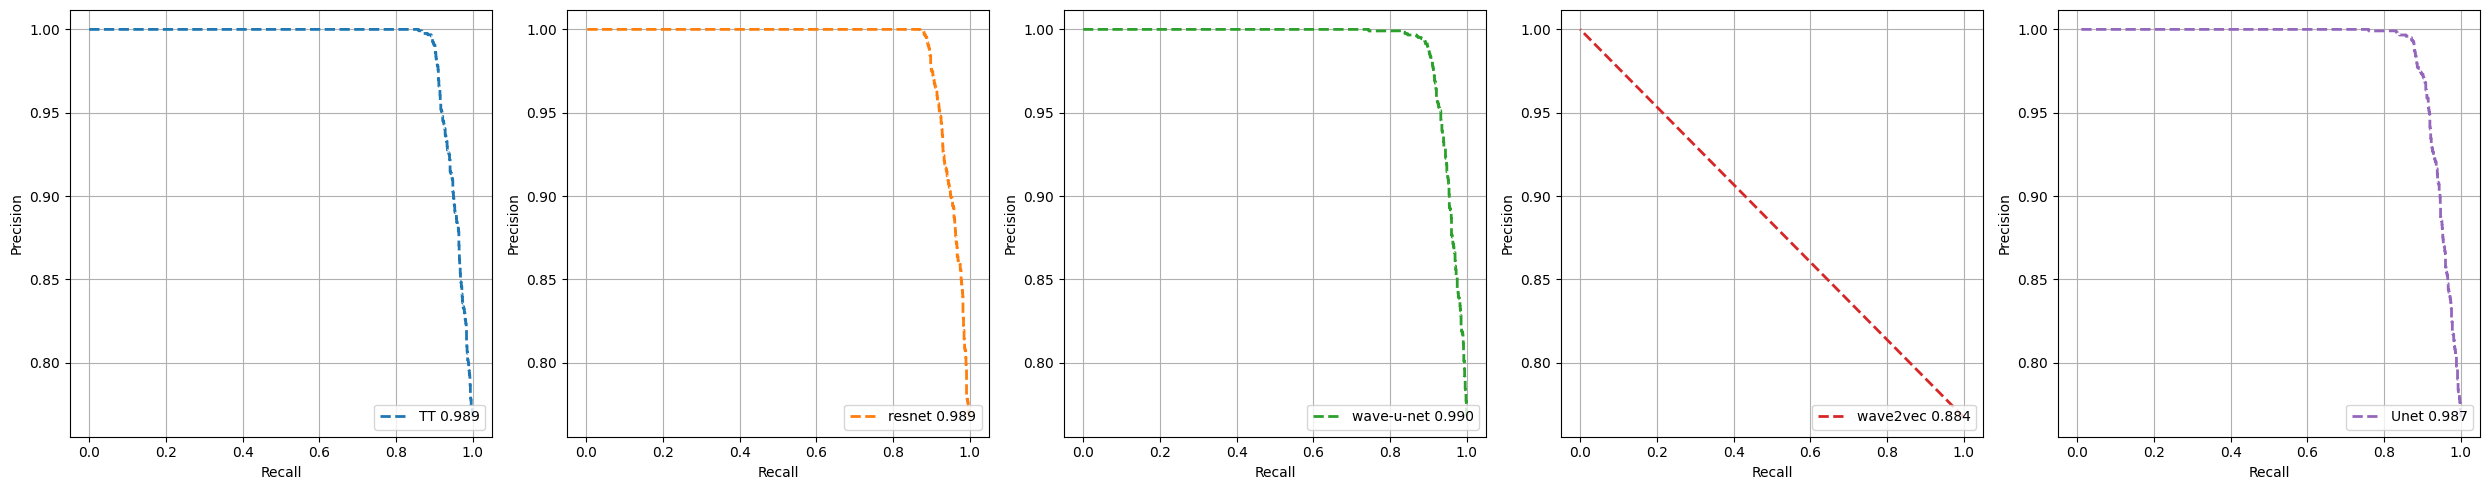

In [ ]:
#plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])

fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for i in range(5):
    # Pass each axis along with the corresponding model's predictions.
    # You can customize the line style and color if desired.
    plot_prc(axes[i], model_name[i], y_test, test_predictions[i],
             color=colors[i % len(colors)], linestyle='--')

plt.tight_layout()
plt.show()

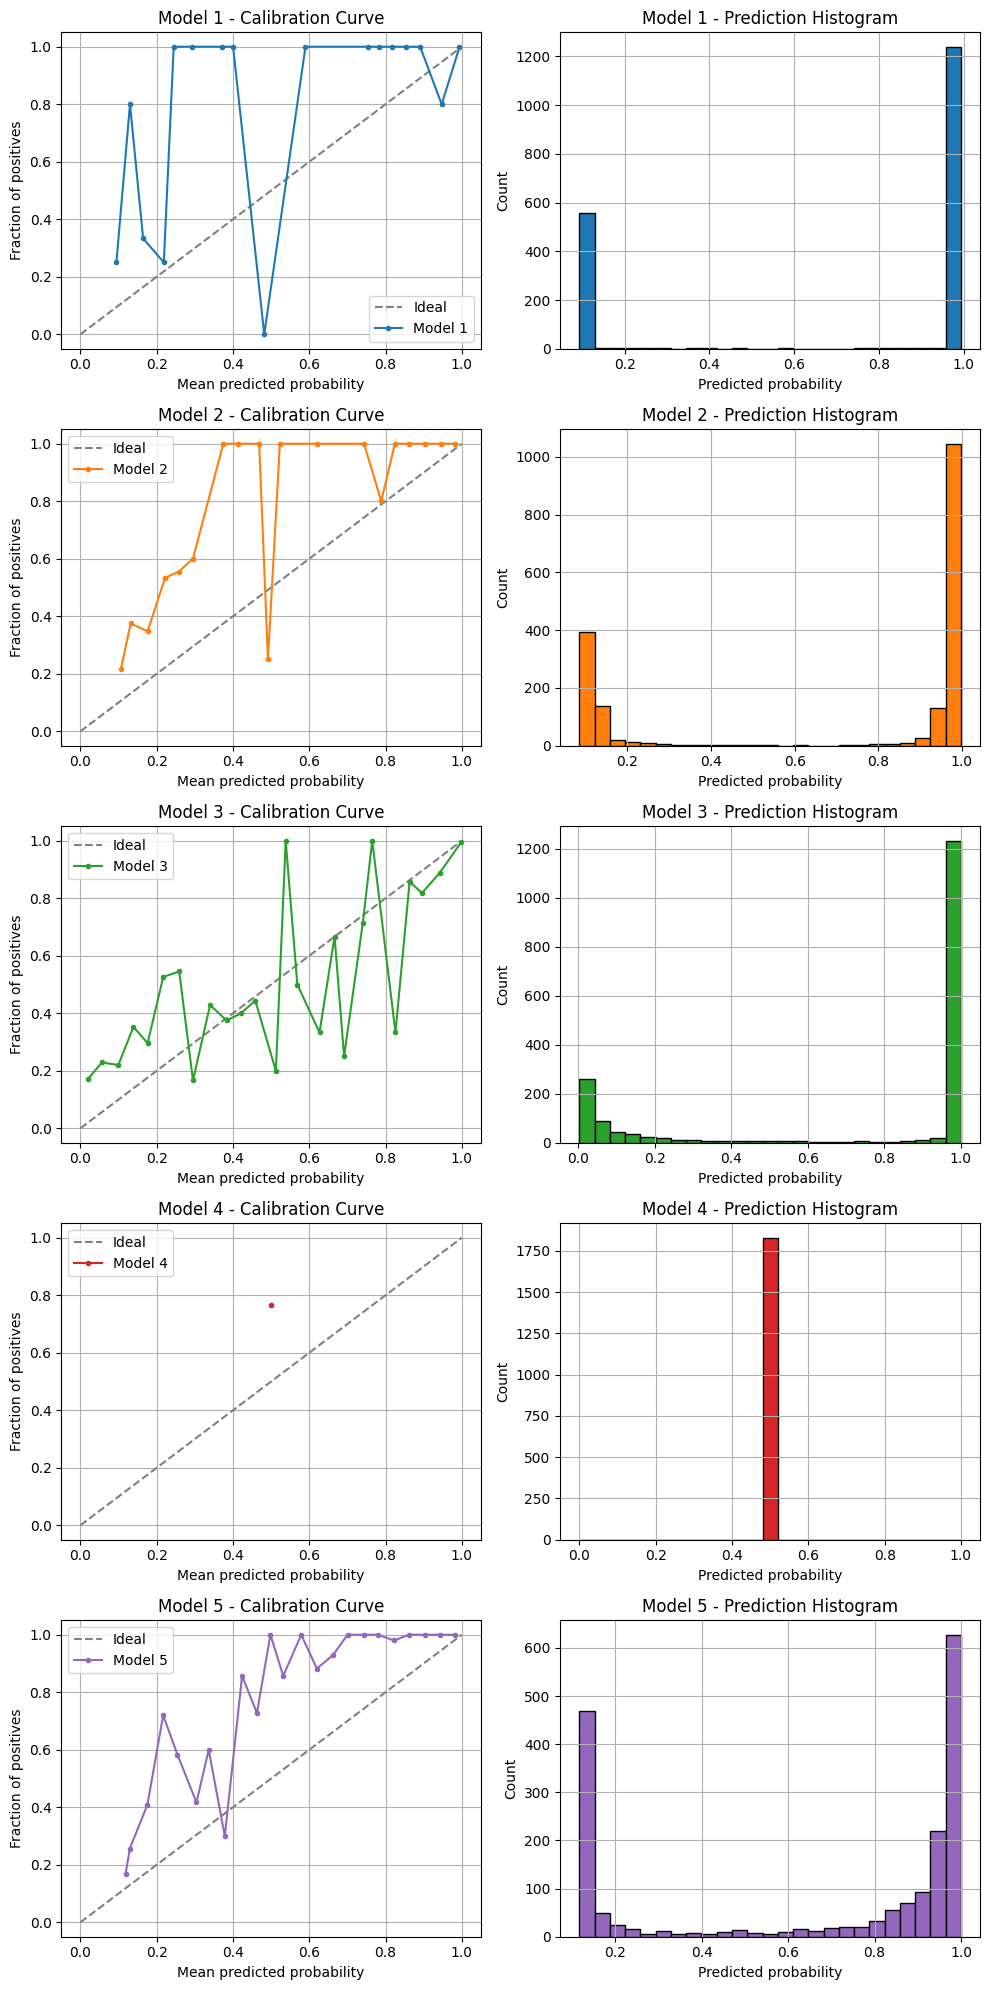

In [ ]:
from sklearn.calibration import calibration_curve

def plot_calibration_diagram(ax_row, name, labels, predictions, n_bins=25, **kwargs):
    """
    Plots a calibration curve (reliability diagram) and a histogram of predictions
    on a given row of axes.
    """
    # Convert one-hot labels to 1D if necessary
    if labels.ndim > 1 and labels.shape[1] > 1:
        labels = np.argmax(labels, axis=1)

    # If predictions are 2D, use the score for the positive class
    if predictions.ndim > 1 and predictions.shape[1] > 1:
        predictions = predictions[:, 1]


    # Compute calibration curve
    prob_true, prob_pred = calibration_curve(labels, predictions, n_bins=n_bins)

    # Plot calibration curve
    ax_row[0].plot([0, 1], [0, 1], label="Ideal", linestyle="--", color="gray")
    ax_row[0].plot(prob_pred, prob_true, marker=".", label=name, **kwargs)
    ax_row[0].set_title(f"{name} - Calibration Curve")
    ax_row[0].set_xlabel("Mean predicted probability")
    ax_row[0].set_ylabel("Fraction of positives")
    ax_row[0].grid(True)
    ax_row[0].legend()

    # Plot histogram of predicted probabilities
    ax_row[1].hist(predictions, bins=n_bins, color=kwargs.get("color", "blue"), edgecolor="black")
    ax_row[1].set_title(f"{name} - Prediction Histogram")
    ax_row[1].set_xlabel("Predicted probability")
    ax_row[1].set_ylabel("Count")
    ax_row[1].grid(True)


# Create a figure with 5 rows and 2 columns (one row per model, two plots per row)
fig, axes = plt.subplots(5, 2, figsize=(10, 20))
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for i in range(5):
    plot_calibration_diagram(axes[i],
                             name=f"Model {i+1}",
                             labels=y_test,
                             predictions=test_predictions[i],
                             n_bins=25,
                             color=colors[i % len(colors)])

plt.tight_layout()
plt.show()

In [ ]:
print("Keras version:", keras.__version__)
print("TensorFlow version:", tf.__version__)
print("librosa version:", librosa.__version__)

Keras version: 3.3.3
TensorFlow version: 2.15.0
librosa version: 0.10.2.post1
